# DATASCI W261: Machine Learning at Scale
## Assignment Week 9
Miki Seltzer (miki.seltzer@berkeley.edu)<br>
W261-2, Spring 2016<br>
Submission: 

In [1]:
# We will need these so we can reload modules as we modify them
%load_ext autoreload
%autoreload 2

In [69]:
# Create job flow so that we don't need to keep spinning up clusters
!python -m mrjob.tools.emr.create_job_flow

using configs in /etc/mrjob.conf
using existing scratch bucket mrjob-ac40f1afcc0b86ce
using s3://mrjob-ac40f1afcc0b86ce/tmp/ as our scratch dir on S3
Creating persistent job flow to run several jobs in...
creating tmp directory /tmp/no_script.cloudera.20160315.022815.359670
writing master bootstrap script to /tmp/no_script.cloudera.20160315.022815.359670/b.py
Copying non-input files into s3://mrjob-ac40f1afcc0b86ce/tmp/no_script.cloudera.20160315.022815.359670/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-310YU13KGHNSC
j-310YU13KGHNSC


In [70]:
clusterId = 'j-310YU13KGHNSC'

# HW9.0

### What is PageRank and what is it used for in the context of web search?
PageRank is a ranking algorithm used by Google. At a high level, it provides a measure of "popularity" of pages, due to the underlying assumption that important websites are likely to have more incoming links than unimportant websites.

### What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the steady stade distibution?
We must introduce a "teleportation" factor by scaling the webgraph by $\alpha$ and adding a factor of $(1-\alpha) * (\text{matrix with entries }1/n)$. This results in a Markov matrix since the entries will be strictly positive (Perron-Frobenius theorem).

# HW9.1: MRJob implementation of basic PageRank

Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7). Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).

In [4]:
# Utilize last week's HW to count the number of nodes in the graph
from MRJob_Explore import explore

def countNodes(filename):

    mr_job = explore(args=[filename, '--no-strict-protocols', '--exploreType', 'nodes'])

    output = []
    
    with mr_job.make_runner() as runner:
        runner.run()
        
        for line in runner.stream_output():
            out = mr_job.parse_output_line(line)
            print 'Number of nodes =', '{:,d}'.format(out[1])
    
    return out[1]

## MRJob to initialize the starting PageRank vector with a uniform distribution

This job requires us to do several things:
- Find all nodes in the graph (dangling nodes will not have an explicit neighbors list)
- For each node, maintain graph structure and initialize PageRank to 1/n

In [5]:
%%writefile PageRank_Initialize.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep

class initialize(MRJob):
    
    """
    Get all nodes
    """
    
    #------------------
    # Mapper:
    # - We need to make sure we emit a line for each node in the graph
    # - Right now there are no lines for nodes with no neighbors
    
    def mapper(self, _, line):
        
        # Split fields
        
        fields = line.split('\t')
        key = fields[0]
        stripe = eval(fields[1])
        
        # Emit the key and stripe
        
        yield key, stripe
        
        # For each neighbor, emit a 0
        # We just do this so we catch all nodes
        
        for neighbor in stripe:
            yield neighbor, 0
            
    #------------------
    # Reducer:
    # - We need to deduplicate each of our nodes
    # - If we encounter a value that is a dictionary, these are the neighbors
    # - If we do not encounter any dictionaries, then the node is dangling, we emit an empty neighbor list
    
    def reducer(self, key, values):       
        stripe = {}
        
        # Loop through values for a key to see if it has neighbors
        # If it does, we need to keep the neighbors
        
        for val in values:
            if type(val) == type(stripe):
                stripe = val
                
        # For each key, emit only one thing, which is the neighbor list
        # We should now have a line for each node, even if the neighbor list is empty
        
        yield key, stripe
        
    """
    Normalize length
    """
    
    # Initialize total to 0
    def mapper_norm_init(self):
        self.total = 0.0
    
    # For each key we encounter, increment total
    # We know that we will only encounter each node once
    def mapper_norm(self, key, value):
        yield key, value
        self.total += 1
        
    # Emit the total number of nodes we saw
    def mapper_norm_final(self):
        yield '*', self.total
    
    # To combine the totals if we have multiple mappers
    def combiner_norm(self, key, values):
        if key == '*':
            yield key, sum(values)
        else:
            for val in values:
                yield key, val
        
    # Initialize the totalNodes to 0
    def reducer_norm_init(self):
        self.totalNodes = 0
       
    # If the key is '*', save the sum of the values
    # Otherwise, yield the key, stripe, and 1/n
    def reducer_norm(self, key, values):
        if key == '*':
            self.totalNodes = sum(values)
        else:
            for val in values:
                yield key, (val, 1 / self.totalNodes)
    
    """
    Multi-step pipeline
    """
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer),
            MRStep(mapper_init=self.mapper_norm_init,
                   mapper=self.mapper_norm,
                   mapper_final=self.mapper_norm_final,
                   combiner=self.combiner_norm,
                   reducer_init=self.reducer_norm_init,
                   reducer=self.reducer_norm,
                   jobconf={'mapred.reduce.tasks': 1})
        ]

if __name__ == '__main__':
    initialize.run()

Overwriting PageRank_Initialize.py


## Driver for Initialization

In [6]:
from PageRank_Initialize import initialize

def initializePR(filename, runnerType, outputDir, printOutput):
    
    if runnerType == 'local':
        mr_job = initialize(args=[filename, '--no-strict-protocols'])
        
    elif runnerType == 'hadoop':
        !hdfs dfs -rm -r {outputDir}
        mr_job = initialize(args=[filename, '--no-strict-protocols', '-r', 'hadoop', '--hadoop-home', '/usr/',
                                 '--output-dir', outputDir])
        
    elif runnerType == 'emr':
        !aws s3 rm --quiet {outputDir}
        mr_job = initialize(args=[filename, '--no-strict-protocols', '--no-output', 
                                  '-r', 'emr', '--emr-job-flow-id', clusterId, '--output-dir', outputDir])
        

    with mr_job.make_runner() as runner:
        runner.run()

        if printOutput:
            for line in runner.stream_output():
                print mr_job.parse_output_line(line)

## Check output of initialization

In [323]:
inputFile = 'PageRank-test.txt'
outputDir = '/user/miki/week09/initialize'
n = countNodes(inputFile)

initializePR(inputFile, 'hadoop', outputDir, True)

# Note: we have to do this to preserve JSON protocol for reading in on next job
!rm PageRank-testInitialized.txt
!hdfs dfs -copyToLocal {outputDir + '/part-00000'} PageRank-testInitialized.txt

Number of nodes = 11
Deleted /user/miki/week09/initialize


The have been translated as follows
 mapred.reduce.tasks: mapreduce.job.reduces


('A', [{}, 0.09090909090909091])
('B', [{'C': 1}, 0.09090909090909091])
('C', [{'B': 1}, 0.09090909090909091])
('D', [{'A': 1, 'B': 1}, 0.09090909090909091])
('E', [{'B': 1, 'D': 1, 'F': 1}, 0.09090909090909091])
('F', [{'B': 1, 'E': 1}, 0.09090909090909091])
('G', [{'B': 1, 'E': 1}, 0.09090909090909091])
('H', [{'B': 1, 'E': 1}, 0.09090909090909091])
('I', [{'B': 1, 'E': 1}, 0.09090909090909091])
('J', [{'E': 1}, 0.09090909090909091])
('K', [{'E': 1}, 0.09090909090909091])
rm: cannot remove `PageRank-testInitialized.txt': No such file or directory


## MRJob to iterate over the PageRank algorithm

In this job we need to do the following:
- Distribute a node's PageRank to its neighbors
- Distribute the mass of dangling nodes, and account for teleporting

#### Distribute node's PageRank to neighbors

For each node we encounter, we have the current PageRank (let's call this $\text{PR}_{\text{old}}$), and the list of neighbors. We need to divide the PageRank by the number of neighbors, and emit this to each neighbor. If there are no neighbors, we cannot emit the PageRank anywhere, so we accumulate it to a special key, \*dangling. Once we accumulate the distributed PageRank mass in each node, we have a preliminary PageRank for each node, which we can denote as $\text{PR}_{\text{int}}$.

#### Distribute the mass of dangling nodes and account for teleporting

We have accumulated the total PageRank mass that has not yet been distributed, because there were no neighbors to distribute the mass to. We also need to account for teleporting. Given the dangling mass, $m$, and the damping factor, $\alpha$, and $n$ nodes, we have the following:

$$
\text{PR}_{\text{new}} = (1-\alpha) \bigg(\frac{1}{n}\bigg) + \alpha\bigg(\frac{m}{n} + \text{PR}_{\text{int}}\bigg)
$$

In [7]:
%%writefile PageRank_Iterate.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol

class iterate(MRJob):

    #------------------
    # Configurations: 
    
    def configure_options(self):
        super(iterate, self).configure_options()
        self.add_passthrough_option('--numNodes', default=1, type='int')
        self.add_passthrough_option('--alpha', default=0.85, type='float')
        self.add_passthrough_option('--iterations', default=1, type='int')
    
    INPUT_PROTOCOL = JSONProtocol
    
    #------------------
    # Mapper:
    # - Find the number of neighbors for the node
    # - Distribute current PageRank among all neighbors
    # - If there are no neighbors, keep track of dangling mass
    
    def mapper_dist(self, key, value):

        # Divide the current PageRank by the number of neighbors
        
        numNeighbors = len(value[0])
        PageRank = value[1]
        
        # If there are neighbors, distribute the PageRank to each neighbors
        
        if numNeighbors > 0:
            for neighbor in value[0]:
                yield neighbor, PageRank / numNeighbors
                
        # If there are no neighbors, we need to account for this dangling node
        
        else:
            yield '*dangling', PageRank
        
        # Maintain the graph structure
        
        yield key, value[0]
     
    #------------------
    # Reducer:
    # - For each node, accumulate PageRank distributed from other nodes
    # - Maintain graph structure
    
    def reducer_dist(self, key, values):
        
        new_PageRank = 0.0
        neighbors = {}
        
        for val in values:
            if type(val) == type(0.0):
                new_PageRank += val
            elif type(val) == type({}):
                neighbors = val

        yield key, (neighbors, new_PageRank)

    #------------------
    # Mapper: 
    # - Account for teleportation
    # - Distribute dangling mass to all nodes
    
    # Below is doing it with only one reducer
    # This isn't a good way to do it, but couldn't figure out a better way
    
    def mapper_dangle(self, key, value):
        yield key, value
        
    def reducer_init(self):
        self.m = 0.0
        
    def reducer_dangle(self, key, values):
        
        PageRank = 0
        neighbors = {}
        
        for val in values:
            PageRank = val[1]
            neighbors = val[0]
            
        if key == '*dangling':
            self.m = PageRank
        else:
            a = self.options.alpha
            n = self.options.numNodes
            new_PageRank = (1 - a) / n + a * (self.m / n + PageRank)
            yield key, (neighbors, new_PageRank)
            
    #------------------
    # Pipeline:
    
    def steps(self):
        return ([
            MRStep(mapper=self.mapper_dist,
                   reducer=self.reducer_dist),
            MRStep(mapper=self.mapper_dangle,
                   reducer_init=self.reducer_init,
                   reducer=self.reducer_dangle,
                   jobconf={'mapred.reduce.tasks': 1})
            ] * self.options.iterations)

if __name__ == '__main__':
    iterate.run()

Overwriting PageRank_Iterate.py


## Driver for Iteration

In [8]:
from PageRank_Iterate import iterate

def iteratePR(filename, n, a, runnerType, outputDir, iterations, printOutput):

    output = []

    if runnerType == 'local':
        mr_job = iterate(args=[filename, '--no-strict-protocols', '--numNodes=' + str(n), 
                               '--alpha=' + str(a), '--iterations=' + str(iterations)])

    elif runnerType == 'hadoop':
        !hdfs dfs -rm -r {outputDir}
        mr_job = iterate(args=[filename, '--no-strict-protocols', '-r', 'hadoop', '--hadoop-home', '/usr/',
                               '--output-dir', outputDir, '--numNodes=' + str(n),
                               '--alpha=' + str(a), '--iterations=' + str(iterations)])

    elif runnerType == 'emr':
        !aws s3 rm --quiet {outputDir}
        mr_job = iterate(args=[filename, '--no-strict-protocols', '--no-output', '--numNodes=' + str(n),
                               '-r', 'emr', '--emr-job-flow-id', clusterId, '--output-dir', outputDir,
                               '--alpha=' + str(a), '--iterations=' + str(iterations)])


    with mr_job.make_runner() as runner:
        runner.run()

        if runnerType != 'emr':
            for line in runner.stream_output():
                out = mr_job.parse_output_line(line)
                output.append(out)
                if printOutput:
                    print out

## Check output of iteration

In [355]:
inputFile = 'PageRank-testInitialized.txt'
outputDir = 'PageRank-result.txt'

k = 30

iteratePR(inputFile, n, 0.85, 'local', outputDir, k, True)

('A', [{}, 0.032781494002798])
('B', [{'C': 1}, 0.3835968127677898])
('C', [{'B': 1}, 0.3437144165952493])
('D', [{'A': 1, 'B': 1}, 0.03908709308143793])
('E', [{'B': 1, 'D': 1, 'F': 1}, 0.0808856947407923])
('F', [{'B': 1, 'E': 1}, 0.03908709308143793])
('G', [{'B': 1, 'E': 1}, 0.016169479146098883])
('H', [{'B': 1, 'E': 1}, 0.016169479146098883])
('I', [{'B': 1, 'E': 1}, 0.016169479146098883])
('J', [{'E': 1}, 0.016169479146098883])
('K', [{'E': 1}, 0.016169479146098883])


# HW9.2: Exploring PageRank teleportation and network plots

In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1].

In [310]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def createGraph(filename, damping):
    
    G = nx.DiGraph()
    sizes = {}
    labels = {}
    
    plt.figure(figsize=(6,4))
    
    # Read in nodes and PageRanks
    with open(filename, 'r') as infile:
        for line in infile:
            fields = line.strip().split('\t')
            node = eval(fields[0])
            stripe = eval(fields[1])
            PageRank = stripe[1]
            neighbors = stripe[0]
            
            # Add node to graph G, scale PageRank, create labels
            G.add_node(node)
            sizes[node] = PageRank * 15000
            labels[node] = str(node) + '\n' + str(round(PageRank, 3) * 100) + '%'
            
            # Add edges to graph G
            for dest in neighbors:
                G.add_edge(node, dest)
    
    # Create positions for nodes
    pos = nx.circular_layout(G)
    
    # Create positions for labels
    label_pos = {}
    scale = 1.25
    for p in pos:
        x = pos[p][0]
        y = pos[p][1]
        if sizes[p] < 1200:
            x *= scale
            y *= scale
        label_pos[p]= (x, y)
        
    # Draw graph!
    nx.draw(G, pos, with_labels=False, arrows=True, node_size=[sizes[x] for x in G.nodes()],
                     node_color=[1/sizes[x] for x in G.nodes()], cmap=plt.cm.gist_rainbow)
    nx.draw_networkx_labels(G, label_pos, labels)
    plt.title('Damping = ' + str(damping))

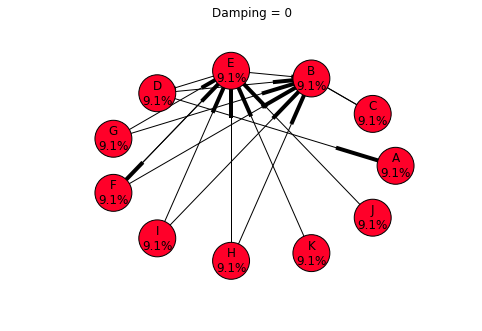

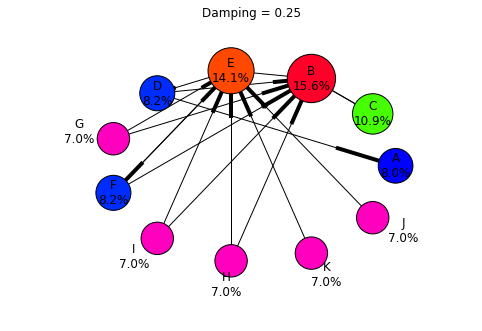

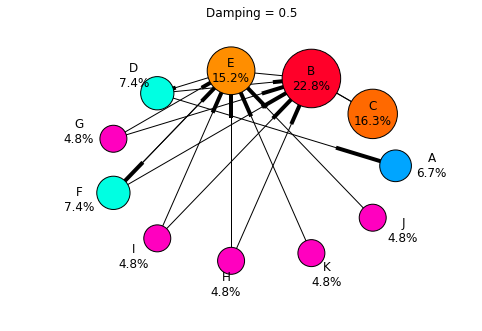

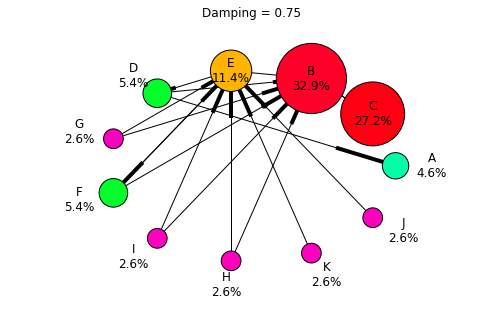

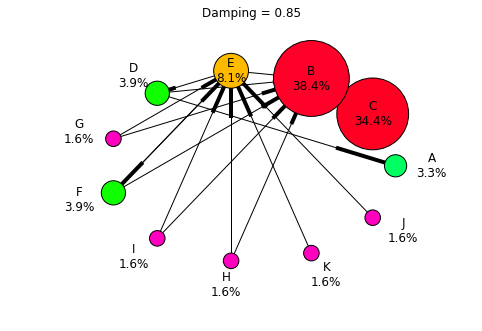

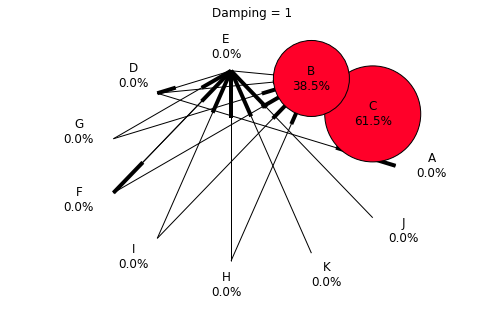

In [314]:
inputFile = 'PageRank-testInitialized.txt'
outputDir = 'PageRank-result.txt'
k = 30

damping = [0, 0.25, 0.5, 0.75, 0.85, 1]

for d in damping:
    iteratePR(inputFile, n, d, 'local', outputDir, k, False)
    createGraph(outputDir, d)

# HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

Run your PageRank implementation on the Wikipedia dataset for 5 iterations, and display the top 100 ranked nodes (with alpha = 0.85)

## MRJob to get top 100 nodes sorted by PageRank

In [67]:
%%writefile PageRank_TopN.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol
from math import log, exp

class topN(MRJob):
    
    #------------------
    # Configurations:
    
    def configure_options(self):
        super(topN, self).configure_options()
        self.add_passthrough_option('--top', default=10, type='int')

    
    INPUT_PROTOCOL = JSONProtocol
    
    #------------------
    # Mapper:
    # - Throw out graph structure
    # - Use PageRank as key
    
    def mapper(self, key, value):
        yield log(value[1]), key
        
    #------------------
    # Reducer:
    # - Take top N values
    
    def reducer_init(self):
        self.seen = 0
    
    def reducer(self, key, values):
        n = self.options.top
        
        for val in values:
            if self.seen < n:
                yield exp(key), val
                self.seen += 1
                
    #------------------
    # Pipeline:
    
    def steps(self):
        return [MRStep(mapper=self.mapper,
                       reducer_init=self.reducer_init,
                       reducer=self.reducer,
                       jobconf={'mapred.output.key.comparator.class':'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                                'mapred.text.key.partitioner.options':'-k1,1',
                                'stream.num.map.output.key.fields':1,
                                'mapred.text.key.comparator.options':'-k1,1nr',
                                'mapred.reduce.tasks': 1
                               })]

        
if __name__ == '__main__':
    topN.run()

Overwriting PageRank_TopN.py


## Driver for top N

In [68]:
from PageRank_TopN import topN

def topNPR(filename, n, runnerType, outputDir, printOutput):

    output = []
    
    if runnerType == 'local':
        mr_job = topN(args=[filename, '--no-strict-protocols', '--top=' + str(n)])

    elif runnerType == 'hadoop':
        !hdfs dfs -rm -r {outputDir}
        mr_job = topN(args=[filename, '--no-strict-protocols', '-r', 'hadoop', '--hadoop-home', '/usr/',
                            '--output-dir', outputDir, '--top=' + str(n)])

    elif runnerType == 'emr':
        !aws s3 rm --quiet {outputDir}
        mr_job = topN(args=[filename, '--no-strict-protocols', '--no-output', '--top=' + str(n),
                            '-r', 'emr', '--emr-job-flow-id', clusterId, '--output-dir', outputDir])


    with mr_job.make_runner() as runner:
        runner.run()

        if runnerType != 'emr':
            for line in runner.stream_output():
                out = mr_job.parse_output_line(line)
                output.append(out)
                if printOutput:
                    print out

## Initialize the Wikipedia data

In [5]:
inputFile = 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'
outputDir = 's3://ms-w261-hw09/wikipedia/initialize'

initializePR(inputFile, 'emr', outputDir)

## Iterate over Wikipedia data 5 times

In [362]:
inputFile = 's3://ms-w261-hw09/wikipedia/initialize/'
outputDir = 's3://ms-w261-hw09/wikipedia/result'

n = 15192277 # We know this from last week's HW
k = 5

iteratePR(inputFile, n, 0.85, 'emr', outputDir, k, False)

## Iterate over Wikipedia data 5 more times (10 iterations total)

In [11]:
inputFile = 's3://ms-w261-hw09/wikipedia/result/'
outputDir = 's3://ms-w261-hw09/wikipedia/result2'

n = 15192277 # We know this from last week's HW
k = 5

iteratePR(inputFile, n, 0.85, 'emr', outputDir, k, False)

## Calculate top 100 pages after 5 iterations

In [72]:
inputFile = 's3://ms-w261-hw09/wikipedia/result/'
outputDir = 's3://ms-w261-hw09/wikipedia/top'

top = 100

topNPR(inputFile, top, 'emr', outputDir, False)

## Top 100 pages after 10 iterations

In [74]:
inputFile = 's3://ms-w261-hw09/wikipedia/result2/'
outputDir = 's3://ms-w261-hw09/wikipedia/top2'

top = 100

topNPR(inputFile, top, 'emr', outputDir, False)

## Compare top pages after 5 and 10 iterations

In [75]:
!aws s3 cp s3://ms-w261-hw09/wikipedia/top/part-00000 wikipediaTop100_5.txt
!aws s3 cp s3://ms-w261-hw09/wikipedia/top2/part-00000 wikipediaTop100_10.txt

download: s3://ms-w261-hw09/wikipedia/top/part-00000 to ./wikipediaTop100_5.txt
download: s3://ms-w261-hw09/wikipedia/top2/part-00000 to ./wikipediaTop100_10.txt


In [76]:
iteration5 = []
iteration10 = []
allIds = set()
pageDict = {}

with open('wikipediaTop100_5.txt', 'r') as f:
    for line in f:
        fields = line.strip().split('\t')
        page = eval(fields[1])
        PR = eval(fields[0])
        iteration5.append([page, PR])
        allIds.add(page)

with open('wikipediaTop100_10.txt', 'r') as f:
    for line in f:
        fields = line.strip().split('\t')
        page = eval(fields[1])
        PR = eval(fields[0])
        iteration10.append([page, PR])
        allIds.add(page)

with open('wikipedia/indices.txt') as f:
    for line in f:
        fields = line.strip().split('\t')
        wikiId = fields[1]
        wikiName = fields[0]
        if wikiId in allIds:
            pageDict[wikiId] = wikiName
    

In [125]:
def printTop(lst, n):
    print '       {:^40s}'.format('After '+str(n)+' iterations')
    print '       {:15s}{:25s}'.format('PageRank', 'Page')
    print '-'*60
    for i in range(100):
        print '[{:3d}]  {:<15.6f}{:25s}'.format(i + 1, lst[i][1], pageDict[lst[i][0]])
    

## Top pages after 5 iterations

In [126]:
printTop(iteration5, 5)

                  After 5 iterations           
       PageRank       Page                     
------------------------------------------------------------
[  1]  0.001461       United States            
[  2]  0.000683       Animal                   
[  3]  0.000643       France                   
[  4]  0.000576       Germany                  
[  5]  0.000460       Arthropod                
[  6]  0.000458       List of sovereign states 
[  7]  0.000455       Insect                   
[  8]  0.000446       Canada                   
[  9]  0.000430       India                    
[ 10]  0.000429       United Kingdom           
[ 11]  0.000422       England                  
[ 12]  0.000409       Iran                     
[ 13]  0.000382       World War II             
[ 14]  0.000369       Poland                   
[ 15]  0.000350       village                  
[ 16]  0.000345       Countries of the world   
[ 17]  0.000332       List of countries        
[ 18]  0.000331       Japan

## Top pages after 10 iterations

In [127]:
printTop(iteration10, 10)

                 After 10 iterations           
       PageRank       Page                     
------------------------------------------------------------
[  1]  0.001461       United States            
[  2]  0.000666       Animal                   
[  3]  0.000640       France                   
[  4]  0.000575       Germany                  
[  5]  0.000450       Arthropod                
[  6]  0.000447       Canada                   
[  7]  0.000445       Insect                   
[  8]  0.000444       List of sovereign states 
[  9]  0.000433       United Kingdom           
[ 10]  0.000428       India                    
[ 11]  0.000423       England                  
[ 12]  0.000398       Iran                     
[ 13]  0.000385       World War II             
[ 14]  0.000363       Poland                   
[ 15]  0.000344       village                  
[ 16]  0.000338       Countries of the world   
[ 17]  0.000329       Japan                    
[ 18]  0.000329       Italy

## Have the top 100 ranked pages changed? Comment on your findings. 
The top 100 pages have not changed drastically between 5 and 10 iterations; the two sets have 98 pages in common.

In [81]:
set5 = set()
set10 = set()

for i in range(100):
    set5.add(iteration5[i][0])
    set10.add(iteration10[i][0])

print 'Intersection of pages from 5 iterations and 10 iterations'
print len(set5.intersection(set10)), 'pages'
print [pageDict[x] for x in set5.intersection(set10)]

Intersection of pages from 5 iterations and 10 iterations
98 pages
['Countries of the world', 'Flowering plant', 'Insect', 'Canada', 'Washington, D.C.', 'Denmark', 'Paris', 'India', 'Japan', 'Hangul', 'South Africa', 'Bakhsh', 'Pakistan', 'Allmusic', 'Australia', 'Italy', 'National Register of Historic Places', 'Iran', 'New Zealand', 'World War II', 'Chicago', 'Europe', 'Germany', 'Iran Standard Time', 'Communes of France', 'village', 'Finland', 'New York City', 'London', 'Scotland', 'Romanize', 'Political divisions of the United States', 'List of countries', 'gene', 'Mexico', 'Hungary', 'Ontario', 'Plant', 'Arthropod', 'Private Use Areas', 'United Kingdom', 'English language', 'Iran Daylight Time', 'China', 'Chordate', 'association football', 'List of sovereign states', 'Norway', 'Geographic Names Information System', 'Switzerland', 'England', 'Greece', 'Counties of Iran', 'World War I', 'United States', 'genus', 'census', 'AllMusic', 'population density', 'U.S. state', 'Powiat', 'New

## Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run. 

In [82]:
%%writefile PageRank_Matching.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol

class matching(MRJob):
    
    #------------------
    # Configurations:
    
    def configure_options(self):
        super(matching, self).configure_options()
        self.add_passthrough_option('--f', default='wikipediaTop100_5.txt', type='string')
    
    INPUT_PROTOCOL = JSONProtocol
    
    #------------------
    # Mapper:
    # - Stream through one file and only keep entries
    #   matching indexes in the included file
    
    def mapper_init(self):
        self.pages = []
        with open(self.options.f + '.txt', 'r') as f:
            for line in f:
                fields = line.strip().split('\t')
                page = eval(fields[1])
                self.pages.append(page)
            
    def mapper(self, key, value):
        if key in self.pages:
            yield key, value[1]
        
    #------------------
    # Pipeline:
    
    def steps(self):
        return [MRStep(mapper_init=self.mapper_init,
                       mapper=self.mapper)]

        
if __name__ == '__main__':
    matching.run()

Overwriting PageRank_Matching.py


In [83]:
from PageRank_Matching import matching

def getMatches(filename, includeFile, runnerType, outputDir, printOutput):

    output = []
    myFile = includeFile.replace('.txt', '')
    
    if runnerType == 'local':
        mr_job = matching(args=[filename, '--no-strict-protocols', '--file', includeFile, '--f', myFile])

    elif runnerType == 'hadoop':
        !hdfs dfs -rm -r {outputDir}
        mr_job = matching(args=[filename, '--no-strict-protocols', '-r', 'hadoop', '--hadoop-home', '/usr/',
                            '--output-dir', outputDir, '--file', includeFile, '--f', myFile])

    elif runnerType == 'emr':
        !aws s3 rm --quiet {outputDir}
        mr_job = matching(args=[filename, '--no-strict-protocols', '--no-output', '--file', includeFile,
                            '-r', 'emr', '--emr-job-flow-id', clusterId, '--output-dir', outputDir,
                            '--f', myFile])


    with mr_job.make_runner() as runner:
        runner.run()

        if runnerType != 'emr':
            for line in runner.stream_output():
                out = mr_job.parse_output_line(line)
                output.append(out)
                if printOutput:
                    print out

In [84]:
getMatches('s3://ms-w261-hw09/wikipedia/result2/', 
           'wikipediaTop100_5.txt', 
           'emr', 
           's3://ms-w261-hw09/wikipedia/matching', 
           False)

In [85]:
!aws s3 cp  --recursive --quiet s3://ms-w261-hw09/wikipedia/matching/ matching/.
!cat matching/part-* > matching.txt

In [86]:
matching = {}
with open('matching.txt', 'r') as f:
    for line in f:
        fields = line.strip().split('\t')
        page = int(eval(fields[0]))
        PR = eval(fields[1])
        matching[page] = PR

In [87]:
beforeAfter = []
for page, PR in iteration5:
    beforeAfter.append([int(page), PR, matching[int(page)]])

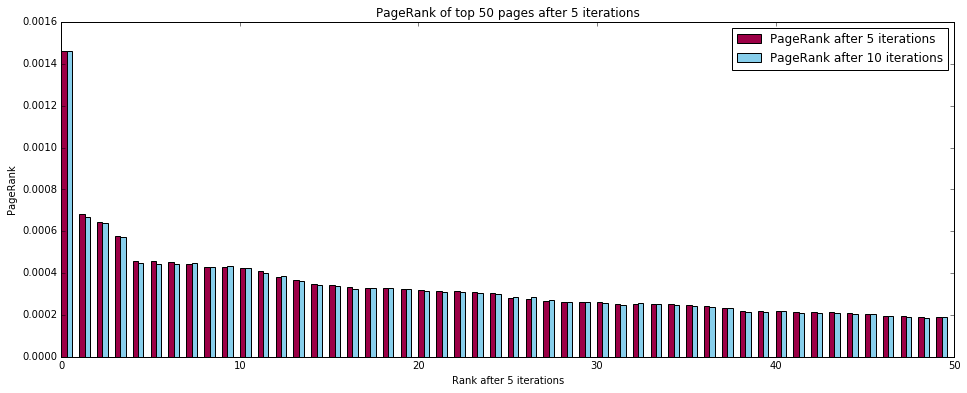

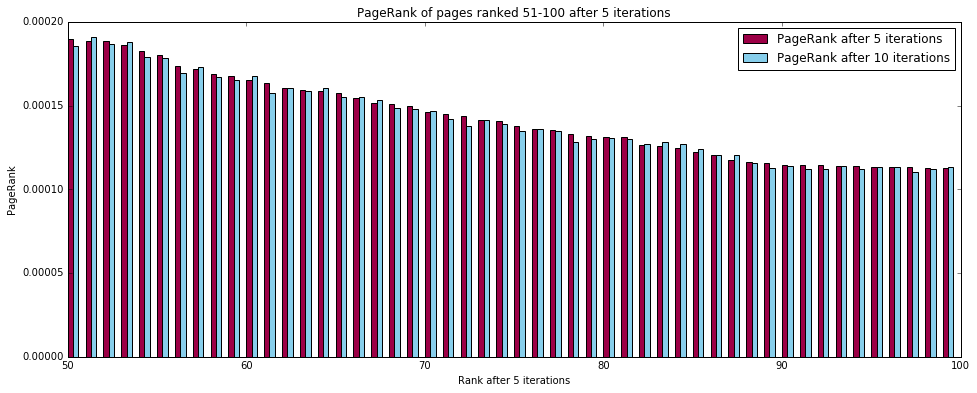

In [128]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

data = np.array(beforeAfter)

def plotData(data, title, startRank=0):
    plt.figure(figsize=(16,6))
    plt.bar(startRank + np.arange(len(data)), data[:,1], width=0.3, color='#9C0046', 
            label='PageRank after 5 iterations')
    plt.bar(startRank + np.arange(len(data)) + 0.3, data[:,2], width=0.3, color='#87ceeb', 
            label='PageRank after 10 iterations')
    plt.title(title)
    plt.ylabel('PageRank')
    plt.xlabel('Rank after 5 iterations')
    plt.legend(loc='upper right')
    plt.xlim(startRank, startRank + len(data))
    

plotData(data[:50,:], "PageRank of top 50 pages after 5 iterations")
print ''
plotData(data[50:,:], "PageRank of pages ranked 51-100 after 5 iterations", 50)

# HW 9.4: Topic-specific PageRank implementation using MRJob

Modify your PageRank implementation to produce a topic specific PageRank implementation

## Initialization for a topic

Since this corpus is small, we will read it in locally and create a topicCount file, so we know how many nodes belong to each topic. This file, along with the topics file will be fed into the initialization MRJob.

In the final reducer of the MRJob (where we normalized the initial PageRank values to be 1/n), we also initialize the weights as follows:

$$
\text{weight}_{ij} = 
\begin{cases}
\frac{\beta}{|T_j|}
&\mbox{if } i \mbox{ in topic } T_j \\
\frac{1-\beta}{N-|T_j|}
&\mbox{if } i \mbox{ not in topic } T_j \\
\end{cases}
$$

In this case, we set $\beta = 0.99$.

In [370]:
from collections import Counter
#We need to do some aggregation of topics
topics = Counter()

with open('randNet_topics.txt', 'r') as myfile:
    for line in myfile:
        fields = line.strip().split('\t')
        topic = fields[1]
        topics[topic] += 1

with open('randNet_topicCount.txt', 'w') as outfile:
    outfile.writelines([str(item) + '\t' + str(topics[item]) + '\n' for item in topics])

In [371]:
%%writefile TSPageRank_Initialize.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep

class initialize(MRJob):
        
    #------------------
    # Configurations: 
    
    def configure_options(self):
        super(initialize, self).configure_options()
        self.add_passthrough_option('--beta', default=0.99, type='float')
        self.add_passthrough_option('--topic', default='1', type='string')
    
    """
    Get all nodes
    """
    
    #------------------
    # Mapper:
    # - We need to make sure we emit a line for each node in the graph
    # - Right now there are no lines for nodes with no neighbors
    
    def mapper(self, _, line):
        
        # Split fields
        
        fields = line.split('\t')
        key = fields[0]
        stripe = eval(fields[1])
        
        # Emit the key and stripe
        
        yield key, stripe
        
        # For each neighbor, emit a 0
        # We just do this so we catch all nodes
        
        for neighbor in stripe:
            yield neighbor, 0
            
    #------------------
    # Reducer:
    # - We need to deduplicate each of our nodes
    # - If we encounter a value that is a dictionary, these are the neighbors
    # - If we do not encounter any dictionaries, then the node is dangling, we emit an empty neighbor list
    
    def reducer(self, key, values):       
        stripe = {}
        
        # Loop through values for a key to see if it has neighbors
        # If it does, we need to keep the neighbors
        
        for val in values:
            if type(val) == type(stripe):
                stripe = val
                
        # For each key, emit only one thing, which is the neighbor list
        # We should now have a line for each node, even if the neighbor list is empty
        
        yield key, stripe
        
    """
    Initialize topic weights (v_ji)
    Normalize length
    """
    
    #------------------
    # Mapper:
    # - Find total number of nodes
    
    # Initialize total to 0
    def mapper_norm_init(self):
        self.total = 0.0
    
    # For each key we encounter, increment total
    # We know that we will only encounter each node once
    def mapper_norm(self, key, value):
        yield key, value
        self.total += 1
        
    # Emit the total number of nodes we saw
    def mapper_norm_final(self):
        yield '*', self.total
    
    #------------------
    # Combiner:
    # - Partial sum of total nodes
    
    # To combine the totals if we have multiple mappers
    def combiner_norm(self, key, values):
        if key == '*':
            yield key, sum(values)
        else:
            for val in values:
                yield key, val
     
    #------------------
    # Reducer:
    # - Partial sum of total nodes
    # - Calculate weight vector (v_ji) for each node
    
    # Initialize the totalNodes to 0
    # Read topics and topicCount (only for topic of interest) into memory
    def reducer_norm_init(self):
        self.totalNodes = 0
        self.topics = {}
        self.topicCount = 0.0
        
        with open('randNet_topics.txt', 'r') as f1:
            for line in f1:
                fields = line.strip().split('\t')
                node = fields[0]
                topic = fields[1]
                self.topics[node] = topic
        
        with open('randNet_topicCount.txt', 'r') as f2:
            for line in f2:
                fields = line.strip().split('\t')
                topic = fields[0]
                count = eval(fields[1])
                if topic == self.options.topic:
                    self.topicCount = count
       
    # If the key is '*', save the sum of the values
    # Otherwise, yield the key, stripe, PageRank (1/n) and weight
    def reducer_norm(self, key, values):
        if key == '*':
            self.totalNodes = sum(values)
        else:
            
            # Is this key is in the topic of interest?
            keyInTopic = self.topics[key] == self.options.topic
            
            # If the key is part of our topic, weight = beta / size of topic
            if keyInTopic:
                weight = self.options.beta / self.topicCount
            
            # Otherwise, weight = (1 - beta) / size of not-topic
            else:
                weight = (1 - self.options.beta) / (self.totalNodes - self.topicCount)
                
            for val in values:
                yield key, (val, 1 / self.totalNodes, weight)
    
    """
    Multi-step pipeline
    """
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer),
            MRStep(mapper_init=self.mapper_norm_init,
                   mapper=self.mapper_norm,
                   mapper_final=self.mapper_norm_final,
                   combiner=self.combiner_norm,
                   reducer_init=self.reducer_norm_init,
                   reducer=self.reducer_norm,
                   jobconf={'mapreduce.job.reduces': 1})
        ]

if __name__ == '__main__':
    initialize.run()

Overwriting TSPageRank_Initialize.py


## Driver for initialization

In [372]:
from TSPageRank_Initialize import initialize

def initializeTSPR(filename, topic, beta, runnerType, outputDir, printOutput):
    
    if runnerType == 'local':
        mr_job = initialize(args=[filename, '--no-strict-protocols', '--topic', topic, '--beta=' + str(beta),
                                 '--file', 'randNet_topics.txt', '--file', 'randNet_topicCount.txt'])
        
    elif runnerType == 'hadoop':
        !hdfs dfs -rm -r {outputDir}
        mr_job = initialize(args=[filename, '--no-strict-protocols', '-r', 'hadoop', '--hadoop-home', '/usr/',
                                 '--output-dir', outputDir, '--topic', topic, '--beta=' + str(beta),
                                 '--file', 'randNet_topics.txt', '--file', 'randNet_topicCount.txt'])
        
    elif runnerType == 'emr':
        !aws s3 rm --quiet {outputDir}
        mr_job = initialize(args=[filename, '--no-strict-protocols', '--no-output', 
                                  '-r', 'emr', '--emr-job-flow-id', clusterId, '--output-dir', outputDir,
                                  '--topic', topic, '--beta=' + str(beta),
                                  '--file', 'randNet_topics.txt', '--file', 'randNet_topicCount.txt'])
        

    with mr_job.make_runner() as runner:
        runner.run()

        if printOutput:
            for line in runner.stream_output():
                print mr_job.parse_output_line(line)

## Check initialization output for topic 1

In [373]:
inputFile = 'randNet.txt'
outputDir = '/user/miki/week09/randNet/initialize'
n = countNodes(inputFile)
topic = '1'

initializeTSPR(inputFile, topic, 0.99, 'hadoop', outputDir + topic, False)

# Note: we have to do this to preserve JSON protocol for reading in on next job
# For some reason, reading input from HDFS does not work :(
localFilename = 'randNet/initialize' + topic + '.txt'
!rm {localFilename}
!hdfs dfs -copyToLocal {outputDir + topic + '/part-00000'} {localFilename}

Number of nodes = 100
Deleted /user/miki/week09/randNet/initialize1


In [374]:
!head {localFilename}

"1"	[{"11": 1, "27": 1, "46": 1, "47": 1, "35": 1, "63": 1, "89": 1, "5": 1}, 0.01, 0.00012048192771084348]
"10"	[{"38": 1, "49": 1, "46": 1, "47": 1, "28": 1, "53": 1, "61": 1, "89": 1, "64": 1, "80": 1}, 0.01, 0.058235294117647059]
"100"	[{"10": 1, "39": 1, "48": 1, "33": 1, "51": 1, "53": 1, "52": 1, "67": 1}, 0.01, 0.00012048192771084348]
"11"	[{"39": 1, "12": 1, "21": 1, "46": 1, "43": 1, "55": 1, "89": 1, "7": 1, "84": 1}, 0.01, 0.00012048192771084348]
"12"	[{"26": 1, "59": 1, "16": 1, "33": 1, "29": 1, "99": 1, "88": 1, "2": 1, "100": 1, "95": 1}, 0.01, 0.00012048192771084348]
"13"	[{"54": 1, "52": 1, "77": 1, "65": 1, "92": 1, "85": 1}, 0.01, 0.00012048192771084348]
"14"	[{"11": 1, "34": 1, "3": 1, "64": 1, "65": 1, "91": 1, "86": 1}, 0.01, 0.00012048192771084348]
"15"	[{"13": 1, "21": 1, "49": 1, "45": 1, "37": 1, "99": 1, "74": 1, "92": 1, "87": 1}, 0.01, 0.00012048192771084348]
"16"	[{"24": 1, "10": 1, "58": 1, "57": 1, "65": 1, "9": 1, "85": 1}, 0.01, 0.058235294117647059]


## Iteration for a topic

This should be the same logic as the non-topic-specific version, except when we calculate the PageRank (accounting for teleporting and distributing dangling mass), we use a different weighting. Formerly, we used the following formula:

$$
\text{PR}_{\text{new}} = (1 - \alpha) \bigg(\frac{1}{n}\bigg) + \alpha \bigg(\frac{m}{n} + \text{PR}_{\text{old}}\bigg)
$$

The first $1/n$ term indicated that we could jump to any other node with uniform probability. However, we now have a different probability, which we calculated in the initialization step:

$$
\text{PR}_{\text{new}} = (1 - \alpha) (\text{weight}_{ij}) + \alpha \bigg(\frac{m}{n} + \text{PR}_{\text{old}}\bigg)
$$

In [375]:
%%writefile TSPageRank_Iterate.py
from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol

class iterate(MRJob):

    #------------------
    # Configurations: 
    
    def configure_options(self):
        super(iterate, self).configure_options()
        self.add_passthrough_option('--numNodes', default=1, type='int')
        self.add_passthrough_option('--alpha', default=0.85, type='float')
        self.add_passthrough_option('--iterations', default=1, type='int')
    
    INPUT_PROTOCOL = JSONProtocol
    
    #------------------
    # Mapper:
    # - Find the number of neighbors for the node
    # - Distribute current PageRank among all neighbors
    # - If there are no neighbors, keep track of dangling mass
    
    def mapper_dist(self, key, value):

        # Divide the current PageRank by the number of neighbors
        
        numNeighbors = len(value[0])
        PageRank = value[1]
        
        # If there are neighbors, distribute the PageRank to each neighbors
        
        if numNeighbors > 0:
            for neighbor in value[0]:
                yield neighbor, PageRank / numNeighbors
                
        # If there are no neighbors, we need to account for this dangling node
        
        else:
            yield '*dangling', PageRank
        
        # Maintain the graph structure and weights
        
        yield key, (value[0], value[2])
     
    #------------------
    # Reducer:
    # - For each node, accumulate PageRank distributed from other nodes
    # - Maintain graph structure
    
    def reducer_dist(self, key, values):
        
        new_PageRank = 0.0
        weight = 0.0
        neighbors = {}
        
        for val in values:
            if type(val) == type(0.0):
                new_PageRank += val
            else:
                neighbors = val[0]
                weight = val[1]
                
        
        yield key, (neighbors, new_PageRank, weight)

    #------------------
    # Mapper: 
    # - Account for teleportation
    # - Distribute dangling mass to all nodes
    
    # Below is doing it with only one reducer
    # This isn't a good way to do it, but couldn't figure out a better way
    
    def mapper_dangle(self, key, value):
        yield key, value
        
    def reducer_init(self):
        self.m = 0.0
        
    def reducer_dangle(self, key, values):
        
        PageRank = 0.0
        neighbors = {}
        weight = 0.0
        
        for val in values:
            PageRank = val[1]
            neighbors = val[0]
            weight = val[2]
            
        if key == '*dangling':
            self.m = PageRank
        else:
            a = self.options.alpha
            n = self.options.numNodes
            new_PageRank = (1 - a) * weight + a * (self.m / n + PageRank)
            yield key, (neighbors, new_PageRank, weight)
            
    #------------------
    # Pipeline:
    
    def steps(self):
        return ([
            MRStep(mapper=self.mapper_dist,
                   reducer=self.reducer_dist),
            MRStep(mapper=self.mapper_dangle,
                   reducer_init=self.reducer_init,
                   reducer=self.reducer_dangle,
                   jobconf={'mapreduce.job.reduces': 1})
            ] * self.options.iterations)

if __name__ == '__main__':
    iterate.run()

Overwriting TSPageRank_Iterate.py


## Driver for iteration

In [376]:
from TSPageRank_Iterate import iterate

def iterateTSPR(filename, n, a, runnerType, outputDir, iterations, printOutput):

    output = []

    if runnerType == 'local':
        mr_job = iterate(args=[filename, '--no-strict-protocols', '--numNodes=' + str(n),
                               '--alpha=' + str(a), '--iterations=' + str(iterations)])

    elif runnerType == 'hadoop':
        !hdfs dfs -rm -r {outputDir}
        mr_job = iterate(args=[filename, '--no-strict-protocols', '-r', 'hadoop', '--hadoop-home', '/usr/',
                               '--output-dir', outputDir, '--numNodes=' + str(n),
                               '--alpha=' + str(a), '--iterations=' + str(iterations)])

    elif runnerType == 'emr':
        !aws s3 rm --quiet {outputDir}
        mr_job = iterate(args=[filename, '--no-strict-protocols', '--no-output', '--numNodes=' + str(n),
                               '-r', 'emr', '--emr-job-flow-id', clusterId, '--output-dir', outputDir,
                               '--alpha=' + str(a), '--iterations=' + str(iterations)])


    with mr_job.make_runner() as runner:
        runner.run()

        if runnerType != 'emr':
            for line in runner.stream_output():
                out = mr_job.parse_output_line(line)
                output.append(out)
                if printOutput:
                    print out

## Check iteration output for topic 1 (only 1 iteration)

In [377]:
inputFile = 'randNet/initialize1.txt'
outputDir = '/user/miki/week09/randNet/result1'

topic = '1'
k = 1

iterateTSPR(inputFile, n, 0.85, 'hadoop', outputDir, k, False)

# Note: we have to do this to preserve JSON protocol for reading in on next job
# For some reason, reading input from HDFS does not work :(
localFilename = 'randNet/result' + topic + '.txt'
!rm {localFilename}
!hdfs dfs -copyToLocal {outputDir + '/part-00000'} {localFilename}

Deleted /user/miki/week09/randNet/result1


In [378]:
!head {localFilename}

"1"	[{"11": 1, "27": 1, "46": 1, "47": 1, "35": 1, "63": 1, "89": 1, "5": 1}, 0.0067509186095029462, 0.00012048192771084348]
"10"	[{"38": 1, "49": 1, "46": 1, "47": 1, "28": 1, "53": 1, "61": 1, "89": 1, "64": 1, "80": 1}, 0.017275558020410961, 0.058235294117647059]
"100"	[{"10": 1, "39": 1, "48": 1, "33": 1, "51": 1, "53": 1, "52": 1, "67": 1}, 0.014808841242425578, 0.00012048192771084348]
"11"	[{"39": 1, "12": 1, "21": 1, "46": 1, "43": 1, "55": 1, "89": 1, "7": 1, "84": 1}, 0.0077761031471874848, 0.00012048192771084348]
"12"	[{"26": 1, "59": 1, "16": 1, "33": 1, "29": 1, "99": 1, "88": 1, "2": 1, "100": 1, "95": 1}, 0.0086904027364870743, 0.00012048192771084348]
"13"	[{"54": 1, "52": 1, "77": 1, "65": 1, "92": 1, "85": 1}, 0.011495926379510715, 0.00012048192771084348]
"14"	[{"11": 1, "34": 1, "3": 1, "64": 1, "65": 1, "91": 1, "86": 1}, 0.0082595766181609558, 0.00012048192771084348]
"15"	[{"13": 1, "21": 1, "49": 1, "45": 1, "37": 1, "99": 1, "74": 1, "92": 1, "87": 1}, 0.0145189741

## Find top 10 nodes for topic 1 (after only 1 iteration)

In [379]:
outputDir = '/user/miki/week09/randNet/top'

top = 10

topNPR(localFilename, top, 'hadoop', outputDir + topic, True)

Deleted /user/miki/week09/randNet/top1


The have been translated as follows
 mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
mapred.reduce.tasks: mapreduce.job.reduces
mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class


(0.021090438972791913, '92')
(0.020692116461969404, '77')
(0.020247185004537947, '52')
(0.0201903626602156, '32')
(0.01805451239936534, '98')
(0.01802519310754605, '27')
(0.01727555802041096, '10')
(0.017252465834818778, '46')
(0.016453367710720652, '29')
(0.01626282769518064, '26')


## Run Topic-specific PageRank for topics 1-10

In [384]:
def moveFromHadoop(source, destination):
    # Note: we have to do this to preserve JSON protocol for reading in on next job
    # For some reason, reading input from HDFS does not work :(   
    !rm {destination}
    !hdfs dfs -copyToLocal {source} {destination}

    
for i in range(10):
    topic = str(i + 1)
    
    # Initialize with uniform PageRank and weight vector for topic i + 1
    inputFile = 'randNet.txt'
    outputDir = '/user/miki/week09/randNet/initialize'
    n = countNodes(inputFile)

    initializeTSPR(inputFile, topic, 0.99, 'hadoop', outputDir + topic, False)

    localFilename = 'randNet/initialize' + topic + '.txt'
    moveFromHadoop(outputDir + topic + '/part-00000', localFilename)
    
    # Iterate PageRank algorithm for 10 iterations
    outputDir = '/user/miki/week09/randNet/result'

    k = 10

    iterateTSPR(localFilename, n, 0.85, 'hadoop', outputDir + topic, k, False)

    localFilename = 'randNet/result' + topic + '.txt'
    moveFromHadoop(outputDir + topic + '/part-00000', localFilename)
    
    # Find top 10 pages
    outputDir = '/user/miki/week09/randNet/top'

    top = 10

    topNPR(localFilename, top, 'hadoop', outputDir + topic, False)
    
    localFilename = 'randNet/top' + topic + '.txt'
    moveFromHadoop(outputDir + topic + '/part-00000', localFilename)
    

## Display top 10 nodes from each version

In [1]:
# moveFromHadoop('/user/miki/week09/randNet/top_all/part-00000', 'randNet/top_all.txt')

top10s = {}

for i in range(11):
    if i == 0:
        filename = 'top_all.txt'
    else:
        filename = 'top' + str(i) + '.txt'
    
    top = []
    
    with open('randNet/' + filename, 'r') as myfile:
        for line in myfile:
            fields = line.strip().split('\t')
            PageRank = eval(fields[0])
            node = eval(fields[1])
            top.append([node, PageRank])
    
    top10s[str(i)] = top

In [2]:
# Create a topic dictionary so we can display the topic of each node

topicDict = {}

with open('randNet_topics.txt', 'r') as myfile:
    for line in myfile:
        fields = line.strip().split('\t')
        key = fields[0]
        topic = fields[1]
        topicDict[key] = topic

In [3]:
# Print top 10 for each topic
# Node, topic, PR

def printTable(topicStart, topicEnd):
    colForm = '{:<5s}{:<3s} {:<6.4f} |'.format
    print '     ',
    for i in range(topicStart, topicEnd):
        if i == 0:
            print '{:^16s}|'.format('All Topics'),
        else:
            print '{:^16s}|'.format('Topic ' + str(i)),
    print ''

    print '     ',
    for i in range(topicStart, topicEnd):
        print '{:5s}{:3s} {:^6s} |'.format('node', 'T', 'PR'),

    print '\n-----' + '------------------' * (topicEnd - topicStart)

    for rank in range(10):
        print '[{:2d}] '.format(rank + 1),
        for i in range(topicStart, topicEnd):
            key = top10s[str(i)][rank]
            print colForm(key[0], topicDict[key[0]], key[1]),
        print ''
    print '\n'

## Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result.

In the table below, the top pages for "All Topics" are a mix of nodes from all topics. However, in each of the topic-specific rankings, the top 10 nodes are largely part of the topic of interest. In all cases, the top 6 ranked nodes are all part of the topic of interest. A few exceptions are within topic 1, where the 7th ranked node is from topic 7, and in topic 6, where the 7th ranked node is topic 3. 

In [4]:
printTable(0, 5)
printTable(5, 10)
printTable(10, 11)

         All Topics   |     Topic 1     |     Topic 2     |     Topic 3     |     Topic 4     | 
      node T     PR   | node T     PR   | node T     PR   | node T     PR   | node T     PR   | 
-----------------------------------------------------------------------------------------------
[ 1]  100  8   0.0163 | 32   1   0.0206 | 58   2   0.0308 | 15   3   0.0315 | 63   4   0.0262 | 
[ 2]  15   3   0.0160 | 77   1   0.0205 | 71   2   0.0297 | 70   3   0.0271 | 83   4   0.0218 | 
[ 3]  63   4   0.0160 | 52   1   0.0198 | 9    2   0.0293 | 86   3   0.0265 | 65   4   0.0206 | 
[ 4]  9    2   0.0154 | 92   1   0.0195 | 73   2   0.0289 | 91   3   0.0245 | 78   4   0.0202 | 
[ 5]  74   10  0.0147 | 10   1   0.0186 | 12   2   0.0269 | 66   3   0.0241 | 41   4   0.0199 | 
[ 6]  58   2   0.0145 | 27   1   0.0185 | 59   2   0.0258 | 2    3   0.0237 | 84   4   0.0195 | 
[ 7]  85   7   0.0145 | 85   7   0.0178 | 75   2   0.0248 | 31   3   0.0228 | 79   4   0.0184 | 
[ 8]  61   8   0.0143 | 98   1 